In [1]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to the range [-1, 1]
])


In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 112697264.26it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 56342183.17it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 45282110.12it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10005529.82it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class Generator(nn.Module):
    # All Conv Net is used in both generator and discriminator
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(100, 4*4*1024)
        self.convt1 = nn.ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=2, padding=2, output_padding=1)
        self.convt2 = nn.ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=2, padding=2, output_padding=1)
        self.convt3 = nn.ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=2, padding=2, output_padding=1)
        self.convt4 = nn.ConvTranspose2d(128, 1, kernel_size=(5, 5), stride=2, padding=2, output_padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        B, latent_dim = x.shape
        x = self.linear1(x)
        x = x.view(B, 1024, 4, 4)
        x = self.relu(self.convt1(x))
        x = self.relu(self.convt2(x))
        x = self.relu(self.convt3(x))
        x = self.tanh(self.convt4(x))
        
        return x

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 512, 4, stride=2, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(8192, 512)
        self.fc2 = nn.Linear(512, 1)
        self.relul = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv1(x)
        x = self.relul(x)
        
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.relul(x)
        
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.relul(x)
        
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.relul(x)
        
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc1(x)
        x = self.relul(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

In [32]:
criterion = nn.BCELoss()

device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator_opt = optim.Adam(generator.parameters(), lr=0.0002)
discriminator_opt = optim.Adam(discriminator.parameters(), lr=0.0002)

In [33]:
epochs = 20
latent_dim = 100
batch_size = 128

d_losses, g_losses = list(), list()

for epoch in range(epochs):
    discriminator.train(True)
    for images, _ in train_loader:
        real_images = images.to(device) # Convert image to (B, height*width)
        
        discriminator_opt.zero_grad()
        generator_opt.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1).to(device) # Shape: (B, 1). Filled with ones
        fake_labels = torch.zeros(real_images.size(0), 1).to(device) # Shape : (B, 1). Filled with zeros
        
        real_outputs = discriminator(real_images) # Shape: (B, 1)
        d_loss_real = criterion(real_outputs, real_labels)
        
        noise = torch.randn(real_images.size(0), latent_dim).to(device) #Shape: (B, 100)
        fake_images = generator(noise) # Shape: (B, height*width)
        fake_outputs = discriminator(fake_images)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_losses.append(d_loss.item())
        d_loss.backward()
        discriminator_opt.step()
        
        generator_opt.zero_grad()
        discriminator_opt.zero_grad()
        noise = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_losses.append(g_loss)
        
        g_loss.backward()
        generator_opt.step()
        
    if epoch % 5 == 0:
        print(epoch, d_loss, g_loss)

0 tensor(3.7253e-09, device='cuda:0', grad_fn=<AddBackward0>) tensor(43.6057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
5 tensor(2.4835e-09, device='cuda:0', grad_fn=<AddBackward0>) tensor(43.5579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
10 tensor(2.7319e-08, device='cuda:0', grad_fn=<AddBackward0>) tensor(43.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
15 tensor(1.2418e-09, device='cuda:0', grad_fn=<AddBackward0>) tensor(42.7774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


In [40]:
g_losses

[tensor(3.8674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(4.9820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(6.8102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(7.7202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(7.8966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(8.4388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(9.4705, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(10.3517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(10.4122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(10.5509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(11.3357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(11.9346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(12.5973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(11.9160, device='cuda:0', grad_fn=<Bi

(10, 64, 64, 1)


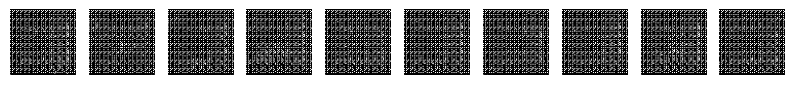

In [38]:
num_samples = 10
noise = torch.randn(num_samples, 100).to(device)
fake_images = generator(noise).cpu().detach().permute(0, 2, 3, 1).numpy()
print(fake_images.shape)

plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(fake_images[i], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
plt.imshow(gen_out[0].detach().permute(1, 2, 0).numpy())